# Kuramoto Sivashinsky


Notebook produzido por:

Gustavo Henrique do Nascimento - 14249084

Marcelo Monari Baccaro - 8989262

Esse notebook foi feito para a disciplina de Inteligência Artificial Informada por Leis Físicas e Modelos de Ordem Reduzida para Engenharia


## Exercício 1b:

A ideia é a produção do dataset a partir da equação de Kuramoto Sivashinky, a partir do setup mostrado no artigo [1].

O material utilizado para obter o dataset foi o do github do Pvlachas: https://github.com/pvlachas/RNN-RC-Chaos/tree/master/Data/KuramotoSivashinskyGP512

### Equação de Kuramoto-Sivashinsky

\begin{equation}\frac{\partial u}{\partial t} = -\nu\frac{\partial^{4} u}{\partial x^{4}} - \frac{\partial^{2} u}{\partial x^{2}}  - u \frac{\partial u}{\partial x}\end{equation}

No domínio:

\begin{equation}\Omega = [0,L] \end{equation}

E condições de contorno:

\begin{equation}u(0,t) = u(L,t)\end{equation}

Nessa equação temos um termo de transporte não linear:

\begin{equation}u \frac{\partial u}{\partial x}\end{equation}

E dois termos dissipativos, represando um balanceamento de escalas, um de quarta ordem

\begin{equation}\nu\frac{\partial^{4} u}{\partial x^{4}}\end{equation}

Outro de segunda ordem

\begin{equation}\frac{\partial^{2} u}{\partial x^{2}}\end{equation}

## Setup
\begin{equation}\nu = 1 \end{equation}
\begin{equation}L = 200 \end{equation}
\begin{equation}\delta t = 0.25 \end{equation}
\begin{equation}d_{o} = 512 \end{equation}
\begin{equation}T = 6 . 10^{4} \end{equation}
\begin{equation}T^{\Lambda 1} \approx 0.094 \end{equation}

[1] - VLACHAS, Pantelis R. et al. Backpropagation algorithms and reservoir computing in recurrent neural networks for the forecasting of complex spatiotemporal dynamics. Neural Networks, v. 126, p. 191-217, 2020.

#se der falha ao importar o scipy, esse comando instala a biblioteca
!pip3 install scipy

In [1]:
import numpy as np #Para trabalhar com os vetores
import matplotlib.pyplot as plt #Biblioteca para gerar os gráficos de saída
from scipy.fft import fft, ifft #Biblioteca para usar as transformadas de Fourrier.

In [2]:
#Parametros iniciais
N = 512 #do
T = 60000 #T
L = 100/(np.pi) #L
dx = (2*np.pi*L)/N
dt = 0.25
nsteps = np.round(T/dt)

In [3]:
#Inicialização
x = dx*np.linspace(1,N,N)
u1 = np.cos(x/L)
u2 = (1+np.sin(x/L))
u = u1*u2
v = fft(u)

In [4]:
#Setup de variáveis de Fourier
k1 = np.array(np.linspace(0,int(N/2)-1,int(N/2)), ndmin = 2)
k1 = np.append(k1,0)
k2 = np.array(np.linspace(int(-N/2)+1,-1,int(N/2)-1), ndmin = 2)
k = np.append(k1,k2)
k = k/L
l = k**2 - k**4

In [5]:
#Setup de variáveis do Runge Kutta de 4a Ordem
E = np.exp(dt*l)
E2 = np.exp(dt*l/2)
M = 16
r = np.exp(1j*np.pi*(np.r_[1:M+1]-0.5)/M)

L_ones = np.array([l for i in range(M)], ndmin = 2).T
r_ones = [r for i in range(N)]
LR = dt*L_ones + r_ones

In [6]:
## Loop para setar alguns parâmetros de Runge Kutta
# Utilizando o git do Pvlachas tinhamos alguns problemas de overflow então esse laço foi
# utilizado para mitigar o problema e obter os dados

eq = np.exp(LR/2) - 1
ef = np.exp(LR)

#Variáveis intermediárias
fi1 = 4 - 3*LR + LR**2
fi2 = -2 + LR
fi3 = -4 - 3*LR - LR**2

for i in range(M):
    for j in range(N):
        eq[j][i] = ((eq[j][i])/(LR[j][i]))
        fi1[j][i] = (ef[j][i]*fi1[j][i] - 4 - LR[j][i])/(LR[j][i]**3)
        fi2[j][i] = (ef[j][i]*fi2[j][i] + 2 + LR[j][i])/(LR[j][i]**3)
        fi3[j][i] = (ef[j][i]*(4-LR[j][i]) + fi3[j][i])/(LR[j][i]**3)
        
Q  = dt*np.real(np.mean(eq, axis = 1))
f1 = dt*np.real(np.mean(fi1, axis =1))
f2 = dt*np.real(np.mean(fi2, axis =1))
f3 = dt*np.real(np.mean(fi3, axis =1))
g  = (-0.5j)*k


In [7]:
nplt = np.floor((nsteps/100)*dt)
nmax = np.round(nsteps)
uu = np.zeros([int(nplt), N], dtype=np.float64)
tt = np.zeros(int(nplt))

In [8]:
#Loop principal para gerar os dados utilizando uma discretização temporal 
#via Exponential Time Differencing 4th order Runge Kutta
i = 0
#Esse laço de repetição, cobre todo o dataset com a discretização 
for n in range(int(nmax)):
    t = n*dt
    Nv = g*fft(np.real(ifft(v))**2)
    a = E2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = E2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = E2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    #No entanto, para conseguirmos mostrar na imagem com o resultado, pegamos somente uma parte
    #do dataset, porque plotar os 240000 requer muito do computador
    if(n%400 == 0):
      u = np.real(ifft(v))
      u = np.array(u, ndmin=2)
      uu[i,:] = u
      tt[i] = t
      i+=1

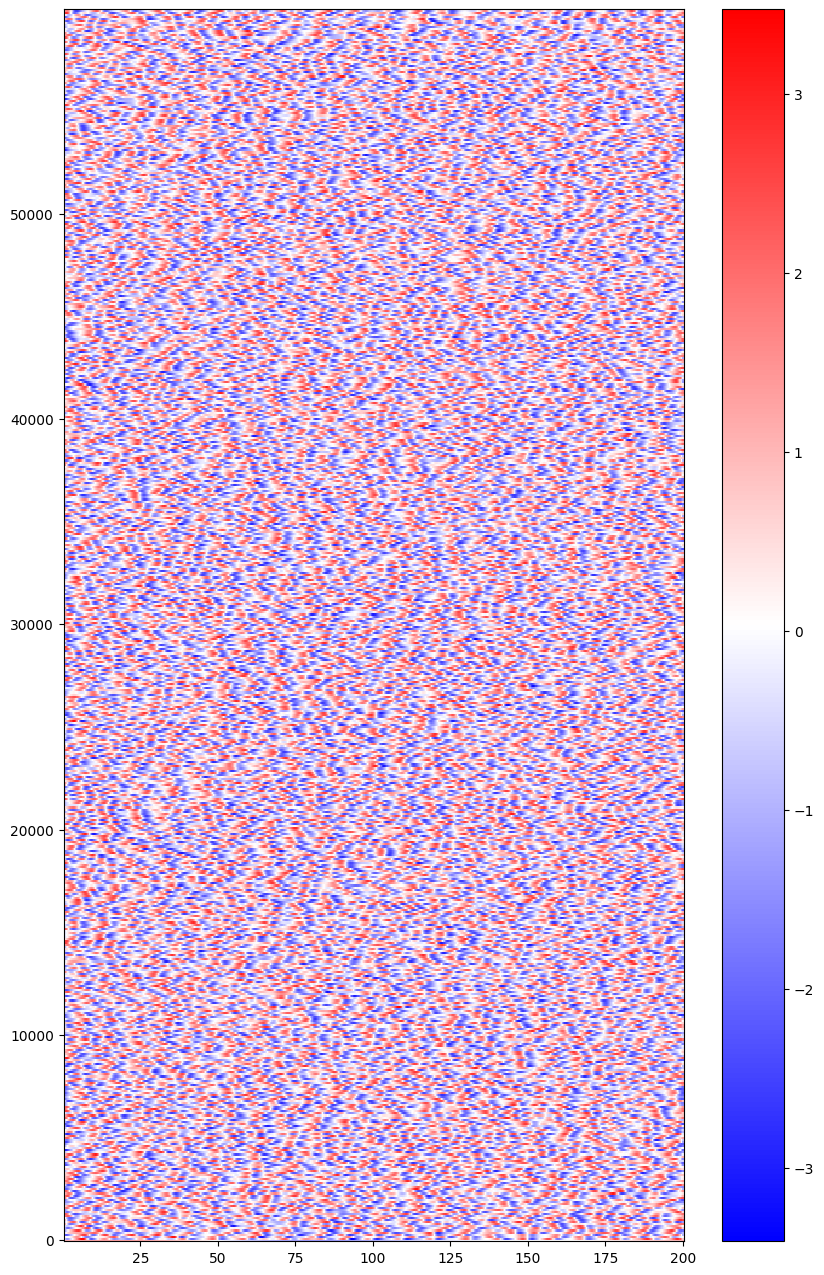

In [10]:
fig, ax1 = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = [10,16]
datamap = ax1.pcolor(x,tt,uu,cmap = 'bwr', vmin=np.min(uu), vmax= np.max(uu), shading='nearest')

fig.colorbar(datamap)

plt.show()